In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

os.chdir("..")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.calibration as calibration
import sklearn.metrics as metrics
import torch

import flippers

# Loading benchmarks from `wrench`

`wrench` is an open source weak supervision benchmark and library created by Jieyu Zhang.

To learn more, visit https://github.com/JieyuZ2/wrench

To get the datasets, you will need to run `sh scripts/download_wrench_datasets.sh` from the root of the repository
Or grab them yourself from https://github.com/JieyuZ2/wrench#-available-datasets

In [4]:
# !cat scripts/download_wrench_datasets.sh
# !sh scripts/download_wrench_datasets.sh

In [5]:
# This helper loads any dataset in the wrench benchmarks
# and creates monopolar label matrices from their multipolar data
def load_wrench_dataset(dataset):
    dataset = "datasets/" + f"{dataset}" + "/{}.json"
    train = pd.read_json(dataset.format("train")).T
    dev = pd.read_json(dataset.format("valid")).T
    test = pd.read_json(dataset.format("test")).T

    L_train, polarities, polarities_mapping = flippers.multipolar_to_monopolar(
        train["weak_labels"].apply(pd.Series)
    )
    L_dev, _, _ = flippers.multipolar_to_monopolar(
        dev["weak_labels"].apply(pd.Series), polarities_mapping
    )
    L_test, _, _ = flippers.multipolar_to_monopolar(
        test["weak_labels"].apply(pd.Series), polarities_mapping
    )

    return (train, dev, test), (L_train, L_dev, L_test), polarities

Choose your dataset here

In [6]:
dataset = "cdr"
# dataset = "yelp"
# dataset = "youtube"
# dataset = "census"
# dataset= "semeval"
# dataset = "spouse"


data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

/home/bern/Repos/flippers/flippers/_core/_core.py:132: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [7]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.6673913043478261, 0.33260869565217394]

# Brief overview of `flippers`

The following is the weak label matrix binary format used by `flippers`.

All labeling functions are unimodal, either predicting 0 ("Abstain") or a 1.

This is different than some other weak supervision libraries like Snorkel, where Abstains are -1, and other outputs are polarized predictions.

In [8]:
L_train

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8425,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8426,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8427,0,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8428,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


The polarity of a labeling function informs which class it is trying to detect.

We have `#|weak labelers| = L.shape[1] = len(polarities)`

In [9]:
polarities

array([1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [10]:
flippers.summary(L_train, polarities)

,polarity,coverage,confidence,overlaps,matched,conflicted
0,1,0.032,1.0,0.028,0.0,0.0
1,1,0.022,1.0,0.018,0.0,0.0
2,1,0.004,1.0,0.004,0.0,0.0
3,0,0.048,1.0,0.048,0.0,0.0
4,0,0.088,1.0,0.087,0.0,0.0
5,0,0.188,1.0,0.170,0.0,0.0
6,0,0.014,1.0,0.014,0.0,0.0
7,1,0.018,1.0,0.018,0.0,0.0
8,1,0.020,1.0,0.020,0.0,0.0
9,0,0.047,1.0,0.047,0.0,0.0


Scoring utils:

In [11]:
y_true = test["label"].astype(int).values


def fill_proba(proba):
    proba = proba.copy()
    proba[L_test.sum(axis=1) == 0] = class_balances[1]
    return proba


Metrics = {}


def score(y_pred, name="", boxplots=True):
    y_pred = fill_proba(y_pred)
    AP = metrics.average_precision_score(y_true, y_pred)
    F1 = metrics.f1_score(y_true, y_pred > 0.5)
    AUC = metrics.roc_auc_score(y_true, y_pred)
    Accuracy = metrics.accuracy_score(y_true, y_pred > 0.5)
    M = {"F1": F1, "Average_Precision": AP, "AUC": AUC, "Accuracy": Accuracy}
    for key, value in M.items():
        print(f"{key}: {value.round(3)}")

    if name:
        global Metrics
        Metrics[name] = M

    if boxplots:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))
        pd.DataFrame({"y_pred": y_pred, "y_true": y_true}).boxplot(
            by="y_true", ax=axs[0]
        )
        axs[0].set_title("Predicted probabilities grouped by ground truth")
        axs[0].set_ylim([0, 1])
        axs[0].get_figure().suptitle("")
        plt.ylabel("y_pred")

        pd.Series(y_pred).plot.box(ax=axs[1])
        axs[1].set_title("Predicted probabilties")
        axs[1].set_ylim([0, 1])
        axs[1].axhline(
            y_true.mean(), color="g", linestyle="--", alpha=0.3, label="Mean of y_true"
        )
        axs[1].legend()
        plt.ylabel("y_pred")
        plt.tight_layout()
        plt.show()

# Training Label Models

## Majority Vote Model

In [12]:
from flippers.models import Voter

F1: 0.613
Average_Precision: 0.586
AUC: 0.821
Accuracy: 0.753


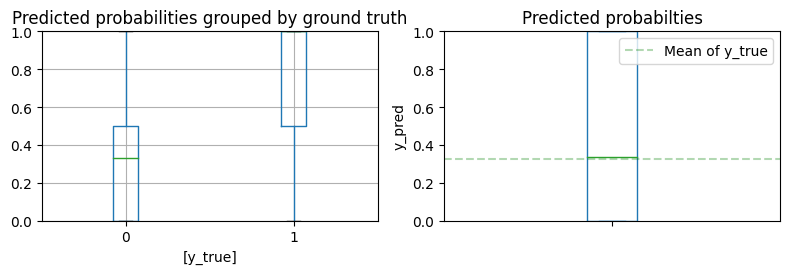

In [13]:
preds_vote = Voter(polarities).predict_proba(L_test)[:, 1]
score(preds_vote, name="MV")

## `flippers`' Snorkel Model

In [14]:
from flippers.models import SnorkelModel

In [15]:
m = SnorkelModel(polarities=polarities, class_balances=class_balances)
m.fit(L_train, learning_rate=5e-3, prec_init=0.8, num_epochs=100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1476.92it/s]


### Update priors with votes and abstains

Last loss 0.04525687950591044

F1: 0.713
Average_Precision: 0.66
AUC: 0.847
Accuracy: 0.782


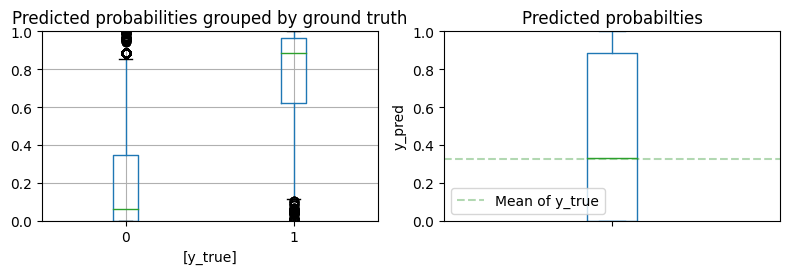

In [16]:
print("Last loss", f"{m.loss_history[-1]}\n")
score(m.predict_proba(L_test)[:, 1], name="flippers_abstains")

### Ignore abstains in prior update

F1: 0.679
Average_Precision: 0.618
AUC: 0.8
Accuracy: 0.758


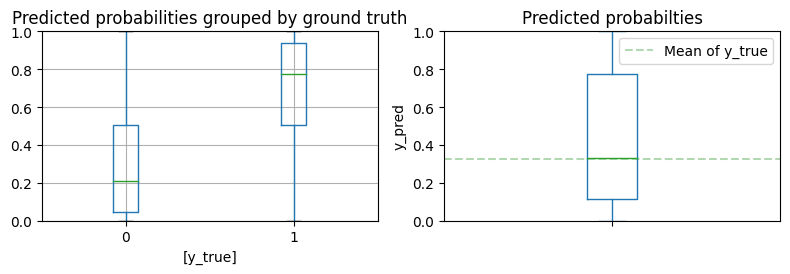

In [17]:
# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
score(m.predict_proba(L_test, "ignore_abstains")[:, 1], name="flippers_ignore_abstains")

## `Snorkel`'s Snorkel model

In [18]:
# Snorkel is not a dependency for flippers' model as it was rewritten from scracth
# !pip install snorkel

In [19]:
from snorkel.labeling.model.label_model import LabelModel

### With priors

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                                                                                                                                                   | 0/100 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.333]
INFO:root:[99 epochs]: TRAIN:[loss=0.022]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1490.12epoch/s]
INFO:root:Finished Training


F1: 0.415
Average_Precision: 0.575
AUC: 0.739
Accuracy: 0.717


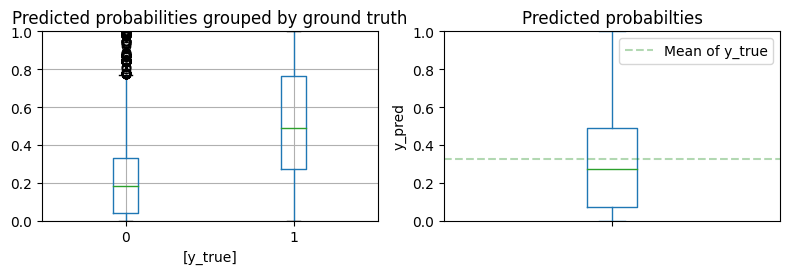

In [20]:
sn = LabelModel()
sn.fit(
    train["weak_labels"].apply(pd.Series).values,
    prec_init=0.8,
    lr=5e-3,
    n_epochs=100,
    class_balance=class_balances,
    log_freq=99,
)
sn_preds = sn.predict_proba(test["weak_labels"].apply(pd.Series).values)[:, 1]

score(sn_preds, name="Snorkel_with_priors")

Sometimes Snorkel does not behave well with class balance priors and its better to leave the default uniform value.

### Without priors

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                                                                                                                                                   | 0/100 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=0.256]
INFO:root:[99 epochs]: TRAIN:[loss=0.021]
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1441.58epoch/s]
INFO:root:Finished Training


F1: 0.678
Average_Precision: 0.602
AUC: 0.785
Accuracy: 0.752


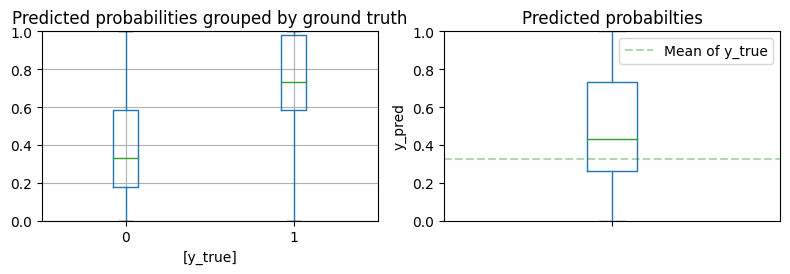

In [21]:
sn = LabelModel()
sn.fit(
    train["weak_labels"].apply(pd.Series).values,
    prec_init=0.8,
    lr=5e-3,
    class_balance=None,
    log_freq=99,
)
sn_preds = sn.predict_proba(test["weak_labels"].apply(pd.Series).values)[:, 1]

score(sn_preds, name="Snorkel_no_priors")

# Final Metric comparison

In [22]:
metrics_df = pd.DataFrame.from_dict(Metrics).T

In [23]:
metrics_df.style.apply(
    lambda x: ["text-decoration: underline" if v == x.max() else "" for v in x], axis=0
)

,F1,Average_Precision,AUC,Accuracy
MV,0.613011,0.586330,0.821305,0.753049
flippers_abstains,0.713279,0.659746,0.847028,0.782367
flippers_ignore_abstains,0.678602,0.618391,0.799958,0.757971
Snorkel_with_priors,0.415194,0.574866,0.738937,0.716670
Snorkel_no_priors,0.678145,0.601560,0.785356,0.751979
